# Autoencoders

## 1. Введение 

Автоэнкодеры – это unsupervised (не требующие разметки для обучения) модели, которые находят применение как базовые строительные блоки в огромном количествеве сложных моделей.

Идея автоэнкодера крайне проста. 
Он состоит из двух нейронных сетей, называемых _энкодером_ и _декодером_, которые работают в тандеме. 
Задача энкодера – сжать исходный объект до вектора малой размерности, называемого _латентным кодом_. 
Задача декодера – восстановить из этого латентного кода исходный объект. 

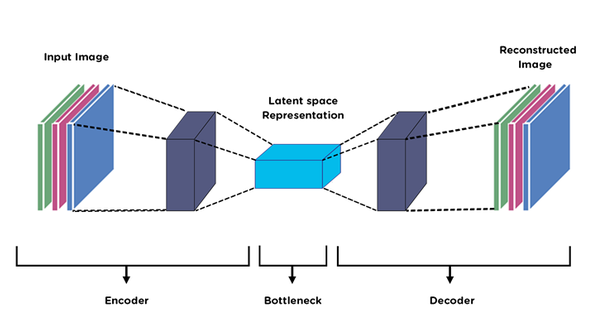

---
Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$ 
Loss = 
\sum_{x_i \in X} MSE(x_i, x_i') =
\sum_{x_i \in X} MSE(x_i, f_{\theta}(g_{\phi}(x_i))
$$

![Архитектура автоэнкодера 2](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

## 2. Пишем простой автоэнкодер для MNIST

Давайте реализуем простейший автоэнкодер, который берет изображения из датасета **MNIST** и кодирует их в латентный код длины **k**. 

В этой части надо реализовать:

* Encoder
    * Четырехслойная полносвязная сеть с размерностями (784-128-64-k)
* Decoder
    * Симметричная полносвязная сеть с размерностями (k-64-128-784)
* Loss функцию для обучения
    * L2 между входом и выходом автоэнкодера

In [1]:
from IPython.display import display
from ipywidgets import Output
from tqdm.auto import trange
from typing import Type, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch import nn
from torch import optim

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size: int = 10) -> None:
        super().__init__()
        
        self.lat_size = lat_size
        
        # YOUR CODE HERE
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        
        return z


class MNISTDecoder(nn.Module):
    def __init__(self, lat_size: int = 10) -> None:
        super().__init__()
        self.lat_size = lat_size
        
        # YOUR CODE HERE
        
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        reconstructed_x = self.decoder(z)
        reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)
        
        return reconstructed_x

In [3]:
class AutoEncoder(nn.Module):
    def __init__(
        self, 
        lat_size: int = 10, 
        encoder_class: Type[MNISTEncoder] = MNISTEncoder, 
        decoder_class: Type[MNISTDecoder] = MNISTDecoder,
        criterion_class: Type[torch.optim.Optimizer] = nn.MSELoss
    ) -> None:
        super().__init__()
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        self.criterion = criterion_class()
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def compute_loss(
        self, 
        x: torch.Tensor, 
        return_reconstruction: bool = False
    ) -> Union[tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        z = # YOUR CODE HERE
        reconstructed_x = # YOUR CODE HERE
        
        loss = self.criterion(x, reconstructed_x)
        
        if return_reconstruction:
            return loss, reconstructed_x
        else:
            return loss

Теперь давайте обучим автоэнкодер

In [4]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
    conditional: bool = False
) -> list[float]:
    model.to(device)
    model.train()
    epoch_loss_trace = []
    
    display()
    out = Output()
    display(out)
    
    for i, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.to(device)
        
        if conditional:
            y = y.to(device)
            loss, reconstructed_x = model.compute_loss(x, y, return_reconstruction=True)
        else:
            loss, reconstructed_x = model.compute_loss(x, return_reconstruction=True)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

        if (i + 1) % verbose_num_iters == 0:
            with out:
                clear_output(wait=True)

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Current epoch loss", fontsize=22)
                plt.xlabel("Iteration", fontsize=16)
                plt.ylabel("Reconstruction loss", fontsize=16)
                plt.grid()
                plt.plot(epoch_loss_trace)

                for j in range(3):
                    plt.subplot(2, 6, 4 + j)
                    plt.axis("off")
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap="gray")

                    plt.subplot(2, 6, 10 + j)
                    plt.axis("off")
                    plt.imshow(reconstructed_x[i, 0].cpu().detach().numpy(), cmap="gray")

                plt.show()
    
    out.clear_output()
    
    return epoch_loss_trace


def train_model(
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int = 5, 
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
    conditional: bool = False
) -> None:
    loss_trace = []
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True):        
        epoch_loss_trace = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            verbose_num_iters=verbose_num_iters,
            device=device,
            conditional=conditional
        )
        
        loss_trace += epoch_loss_trace
        
    plt.figure(figsize=(10, 5))
    plt.title("Total training loss", fontsize=22)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Reconstruction loss", fontsize=16)
    plt.grid()
    plt.plot(loss_trace)
    plt.show()
    
    model.eval()

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="./mnist", 
    train=True,
    download=True, 
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./mnist", 
    train=False,
    download=True, 
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256,
    shuffle=True, 
    num_workers=1
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=256,
    shuffle=False, 
    num_workers=1
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

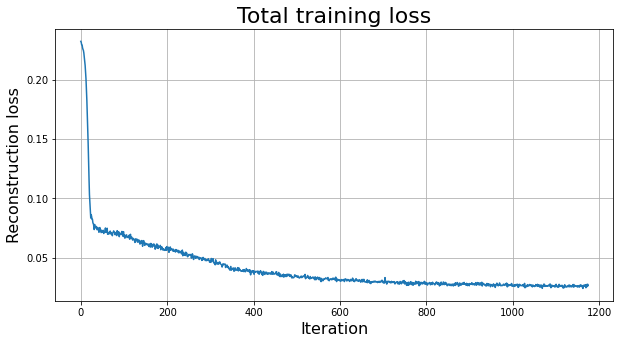

In [6]:
# обучим модель с латентным кодом длины 8
model = AutoEncoder(8)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_dataloader, optimizer, device=device)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

## 3. Структура и интерпретация латентного пространства

Главная ценность автоэнкодера как модели - его латентный код. Он крайне насыщенный, т.к. он должен сохранять как можно больше важной информации об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном пространстве. 

В этой части мы проиллюстрируем эти свойства.

### 3.1 Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответсвующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера. 

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [7]:
x, _ = next(iter(train_dataloader))
    
x1 = x[0].to(device)
x2 = x[1].to(device)

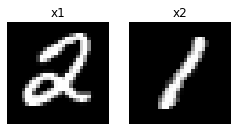

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

axs[0].axis("off")
axs[0].set_title("x1")
axs[0].imshow(x1[0].cpu().detach().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("x2")
axs[1].imshow(x2[0].cpu().detach().numpy(), cmap="gray");

In [9]:
# получите латентные коды объектов
# YOUR CODE HERE

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
# YOUR CODE HERE

# восстановите для всех латентных кодов изображения
# YOUR CODE HERE

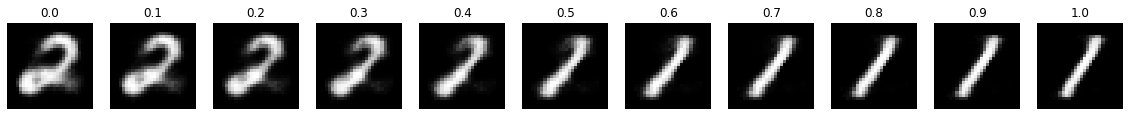

In [10]:
# нарисуем проинтерполированные объекты
fig, axs = plt.subplots(1, 11, figsize=(20, 20))

for i, d in enumerate(np.linspace(0, 1, 11)):
    axs[i].axis("off")
    axs[i].set_title(f"{d:.2}")
    axs[i].imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap="gray")

На интерполяция видно, как один объект плавно превращается в другой. Стоит заметить, что почти все промежуточные объекты тоже выглядят довольно правдопободно. Иногда такие интерполяции используют для того, чтобы расширить какой-то маленький датасет.

### 3.2 Структура латентного пространства

Теперь давайте обучим автоэнкодер с **2** латентными кодами, соберем эти латентные коды и нарисуем 2d plot, где латентные коды подсвечены цветами классов исходных объектов.

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

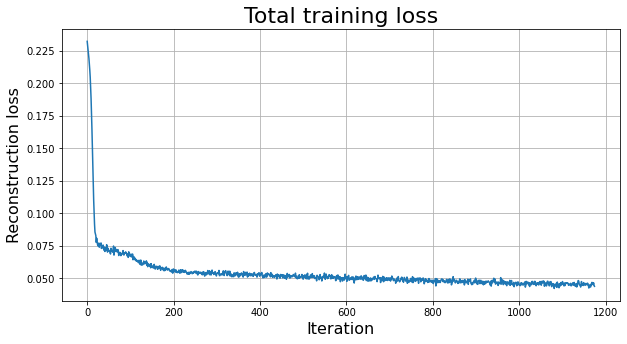

In [11]:
# обучим автоэнкодер с 2 латентными кодами
model_2d = AutoEncoder(2)
optimizer = optim.Adam(model_2d.parameters(), lr=1e-3)
train_model(model_2d, train_dataloader, optimizer, device=device)

In [12]:
def get_latent_codes_and_labels(
    dataloader: torch.utils.data.DataLoader, 
    model: nn.Module, 
    num_objects: int
) -> tuple[torch.Tensor, torch.Tensor]:
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_codes = model.encode(x)
    
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels
    
# соберем для 1000 случайных объектов их латентные коды и классы
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_2d, 1000)

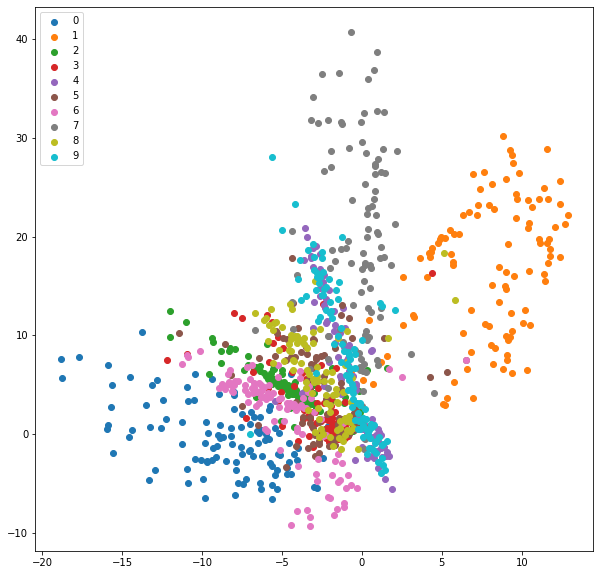

In [13]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
plt.legend()
plt.show()

Объекты одного и то же класса находятся в латентном пространстве близко друг к другу! При этом визуально похожие классы (1-4 или 4-9) тоже находятся близко друг к другу.

### 3.3 Структура латентного пространства (продолжение)

А теперь давайте обучим автоэнкодер с **32** латентными кодами, а потом сожмем до размемрности **2** с помощью **t-sne**.

In [14]:
from sklearn.manifold import TSNE

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

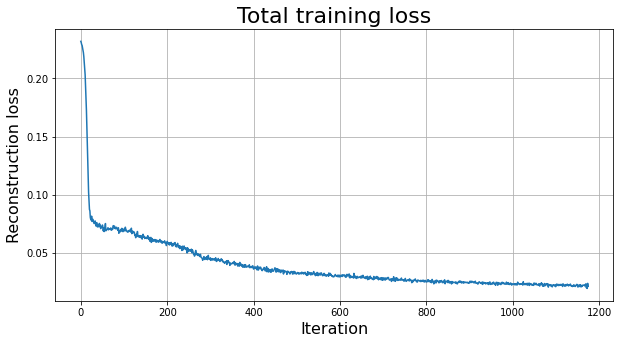

In [15]:
model_big = AutoEncoder(32)
optimizer = optim.Adam(model_big.parameters(), lr=1e-3)
train_model(model_big, train_dataloader, optimizer, device=device)

In [16]:
tsne = TSNE(n_components=2)
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_big, 1000)
new_codes = tsne.fit_transform(lat_codes)

/home/ubuntu/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


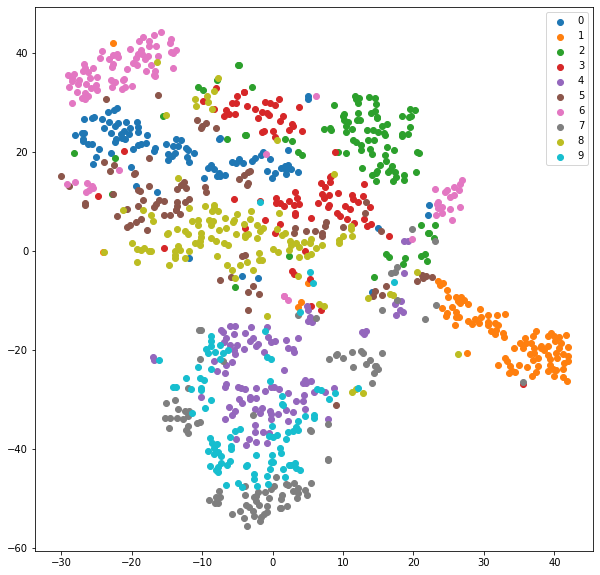

In [17]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = new_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    
plt.legend()
plt.show()

## 4. Denoising

Автоэнкодеры часто используют для очистки исходных данных от шума. Латентный код сохраняет только главную информацию об объекте, отбрасывая шумовые компоненты. 

Давайте реализуем функцию, которая обращает 10% пикселей исходного изображения и обучим на такой выборке автоэнкодер.

In [18]:
class FlipRandomBits(object):
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio
        
    def __call__(self, x):
        mask = (torch.rand_like(x) < self.flip_ratio)
        x[mask] = 1 - x[mask]
        
        return x

transform = transforms.Compose(
    [transforms.ToTensor(), FlipRandomBits()]
)

train_dataset_with_noise = torchvision.datasets.MNIST(
    root="./mnist", 
    train=True,
    download=True, 
    transform=transform
)
train_dataloader_with_noise = torch.utils.data.DataLoader(
    train_dataset_with_noise, 
    batch_size=256,
    shuffle=True, 
    num_workers=1
)

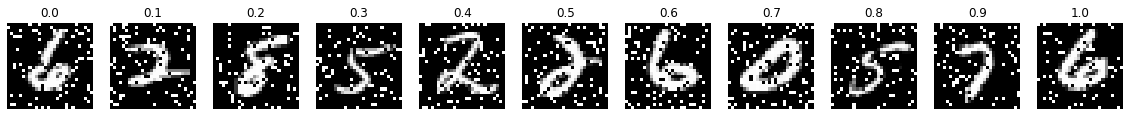

In [19]:
x, y = next(iter(train_dataloader_with_noise))

fig, axs = plt.subplots(1, 11, figsize=(20, 20))

for i, d in enumerate(np.linspace(0, 1, 11)):
    axs[i].axis("off")
    axs[i].set_title(f"{d:.2}")
    axs[i].imshow(x[i, 0].cpu().detach().numpy(), cmap="gray")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

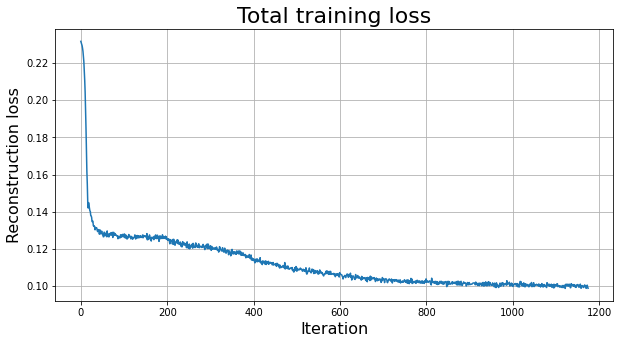

In [20]:
# обучим автоэнкодер на зашумленных данных
model_for_noise = AutoEncoder(64)
optimizer = optim.Adam(model_for_noise.parameters(), lr=1e-3)
train_model(model_for_noise, train_dataloader_with_noise, optimizer, device=device)

In [21]:
_, reconstructed_x = model.compute_loss(x.to(device), return_reconstruction=True)

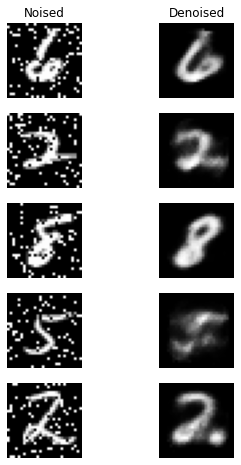

In [22]:
fig, axs = plt.subplots(5, 2, figsize=(5, 8))

for i, (ax, noised, denoised) in enumerate(zip(axs, x[:10], reconstructed_x[:10])):
    ax[0].imshow(noised[0].cpu().detach().numpy(), cmap="gray")
    ax[1].imshow(denoised[0].cpu().detach().numpy(), cmap="gray")
    ax[0].axis("off")
    ax[1].axis("off")
    if i == 0:
        ax[0].set_title(f"Noised")
        ax[1].set_title(f"Denoised")

In [23]:
x, y = next(iter(test_dataloader))
_, reconstructed_x = model.compute_loss(x.to(device), return_reconstruction=True)

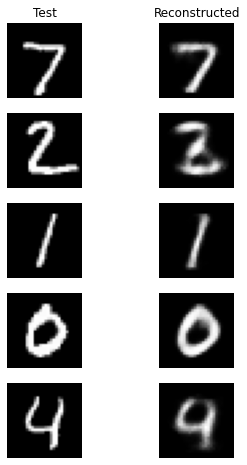

In [24]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)

for i, (ax, noised, denoised) in enumerate(zip(axs, x[:10], reconstructed_x[:10])):
    ax[0].imshow(noised[0].cpu().detach().numpy(), cmap="gray")
    ax[1].imshow(denoised[0].cpu().detach().numpy(), cmap="gray")
    ax[0].axis("off")
    ax[1].axis("off")
    if i == 0:
        ax[0].set_title(f"Test")
        ax[1].set_title(f"Reconstructed")

## 5. Variational AE

В отличие от обычного автоэнкодера, теперь мы будем с помощью энкодера предсказывать не конкретную точку $z$ в латентном представлении, а распределение $q(z | x)$. 
Более того, будем требовать, чтобы наше латентное представление было многомерным нормальным распределнием $\mathcal (\mu, \sigma)$ с параметрами среднего и дисперсии, которые будут получаться из энкодера. 
Технически разница будет в том, что после экнкодинга объекта нам нужно будет получить не один вектор, а два.

Для обучения такой модели мы будем использовать метрику `KL дивергенция`:
$$
KL(p || q) = \int p(x) \log \frac{p(x)}{q(x)} dx.
$$

В дискретном случае интеграл заменится на суммирование:
$$
KL(p || q) = \sum_{x_i \in X} p(x_i) \log \frac{p(x_i)}{q(x_i)}.
$$

В приведённых формулах $p(x)$ и $q(x)$ – это плотности двух произвольных распределений, заданных на одном __носителе__.

KL дивергенцию иногда называют расстоянием между распределениями, но обратите внимание, что в математическом смысле она таковым не является:
- $KL(p || q) = 0$ тогда и только тогда когда $p(x) = q(x)$ всюду
- $KL(p || q) >= 0$ для любых $p$ и $q$
- $KL(p || q)$ __несимметрична__: семплы взвешены по вероятности $p(x)$, поэтому если $p(x)$ близка к нулю, как бы велико $q(x)$ не было, в KL оно добавит не очень много

---
Примерно так будет выглядеть пример, в котором будет минимизироваться KL дивергенция между уни- и бимодальным распределениями.

| До минимизации дивергенции | После                 |
| :----:                 | :----:               |
| ![KL до](kl_after.png) | ![KL после](kl_was.png)|

-----
KL дивергенция - это, конечно, хорошо, но перед тем, как приступить к имплементации модели, давайте для начала вспомним из лекции общий лосс, на который мы будем обучать простую версию VAE:

$$
\sum_{i = 1}^{\ell} \left( \mathbb{E}_{q(z|x_i)} \log p(x_i | z) - KL(q(z | x_i) \; || \; \mathcal{N}(0, 1)) \right) \to max.
$$

На самом деле, из этой записи совсем непонятно ни откуда этот лосс получается, ни как его в действительности считать.
- Для того, чтобы разобраться с первой из этих двух проблем, нужно [немного пожонглировать](https://en.wikipedia.org/wiki/Variational_autoencoder) интегралами и формулой полной вероятности для того, чтобы получить, что указанное выражение является вариационной нижней границей (evidence lower bound, ELBO) для маргинального правдоподобия тренировочной выборки: $\mathcal{L}(X)$. Другими словами, максимизирую это выражение по параметрам автокодировщика, мы будем максимизировать и правдоподобие выборки
- Для того, чтобы решить вторую проблему, нам как минимум нужно понять, что делать с матожиданиями и интегралом в KL дивергенции. С этим всё будет куда проще: интегралы (коими являются и матожидания) можно оценить при помощи метода Монте-Карло. В нашей реализации мы максимально упростим и эту оценку: будем оценивать по одному семплу.

Помимо всего этого, на выходе из VAE обычно предсказывают не напрямую реконструкцию объекта, а параметры `mu_reconstruction` и `sigma_reconstruction` для распределения этой самой реконструкции. 
Мы и тут упростим себе задачу тем, что вместо распределения будем предказывать точечную оценку реконструкции абсолютно аналогично тому, что происходило в обычных автокодировщиках. 
В такой постановке первое слагаемое из формулы лосса станет просто MSE между исходным объектом и декодированным.

In [25]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size: int):
        super().__init__()
        self.lat_size = lat_size

        self.enc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 512), 
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.ReLU()
        )
        
        self.mu = nn.Linear(256, self.lat_size)
        self.log_sigma = nn.Linear(256, self.lat_size)
        
    def forward(self, x: torch.Tensor):
        # YOUR CODE HERE
        
        return mu, log_sigma 


class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size: int):
        super().__init__()
        self.lat_size = lat_size
        
        self.dec = nn.Sequential(
            nn.Linear(self.lat_size, 128), 
            nn.ReLU(),
            nn.Linear(128, 784), 
            nn.Sigmoid()
        )
        
    def forward(self, z: torch.Tensor):
        x_reconstructed = self.dec(z)
        x_reconstructed = x_reconstructed.view(-1, 1, 28, 28)
        
        return x_reconstructed

In [26]:
class VariationalAutoEncoder(nn.Module):
    def __init__(
        self, 
        lat_size: int, 
        KL_weight: float = 0.001,
        encoder_class: Type[MNISTEncoder_vae] = MNISTEncoder_vae, 
        decoder_class: Type[MNISTDecoder_vae] = MNISTDecoder_vae,
        criterion_class: Type[nn.MSELoss] = nn.MSELoss
    ) -> None:
        super().__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.enc(x)
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.dec(z)
    
    def sample_z(
        self, 
        mu: torch.Tensor, 
        log_sigma: torch.Tensor) -> torch.Tensor:
        eps = torch.randn(mu.size(), device=mu.device) # your code here
        
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(
        self, 
        x: torch.Tensor, 
        reconstructed_x: torch.Tensor, 
        mu: torch.Tensor, 
        log_sigma: torch.Tensor
    ) -> torch.Tensor:
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        reconstruction_loss = self.criterion(x, reconstructed_x)
        
        return KL * self.KL_weight + reconstruction_loss
    
    def compute_loss(
        self, 
        x: torch.Tensor, 
        return_reconstruction: bool = False
    ) -> Union[tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        reconstructed_x = self.decode(z)
        
        loss = self.custom_loss(x, reconstructed_x, mu, log_sigma)
        
        if return_reconstruction:
            return loss, reconstructed_x
        else:
            return loss

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

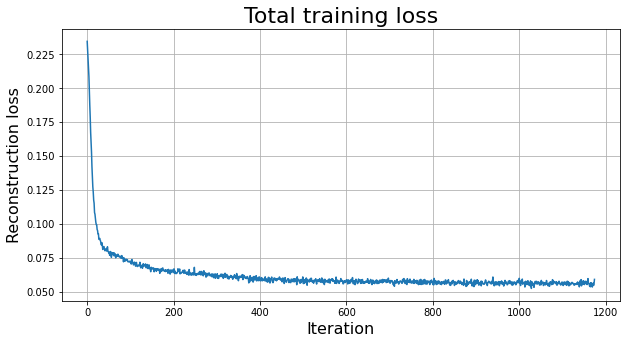

In [27]:
hidden_dim = 2
model_vae = VariationalAutoEncoder(hidden_dim, 0.002)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

train_model(model_vae, train_dataloader, optimizer, 5)

### 5.1 Interpolation of latent codes

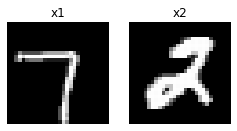

In [28]:
x, _ = next(iter(train_dataloader))
    
x1 = x[0].to(device)
x2 = x[1].to(device)
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

axs[0].axis("off")
axs[0].set_title("x1")
axs[0].imshow(x1[0].cpu().detach().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("x2")
axs[1].imshow(x2[0].cpu().detach().numpy(), cmap="gray");

In [29]:
# получите латентные коды объектов
z_1_mu, z_1_logs = model_vae.encode(x1[None, :, :, :])
z_2_mu, z_2_logs = model_vae.encode(x2[None, :, :, :])
z_1 = model_vae.sample_z(z_1_mu, z_1_logs)
z_2 = model_vae.sample_z(z_2_mu, z_2_logs)

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)

# восстановите для всех латентных кодов изображения
x_linspace = model_vae.decode(z_linspace)

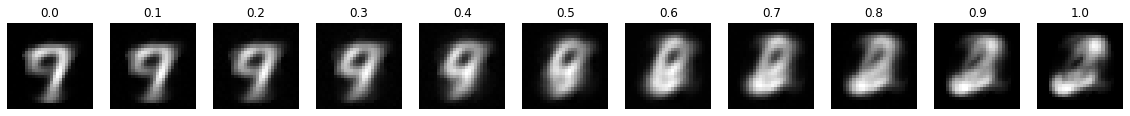

In [30]:
# нарисуем проинтерполированные объекты
fig, axs = plt.subplots(1, 11, figsize=(20, 20))

for i, d in enumerate(np.linspace(0, 1, 11)):
    axs[i].axis("off")
    axs[i].set_title(f"{d:.2}")
    axs[i].imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap="gray")

### 5.2 Структура латентного пространства

In [31]:
def get_latent_codes_and_labels_vae(
    dataloader: torch.utils.data.DataLoader, 
    model: nn.Module, 
    num_objects: int
) -> tuple[torch.Tensor, torch.Tensor]:
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x)
        
        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps
        
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [32]:
lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model_vae, 1000)

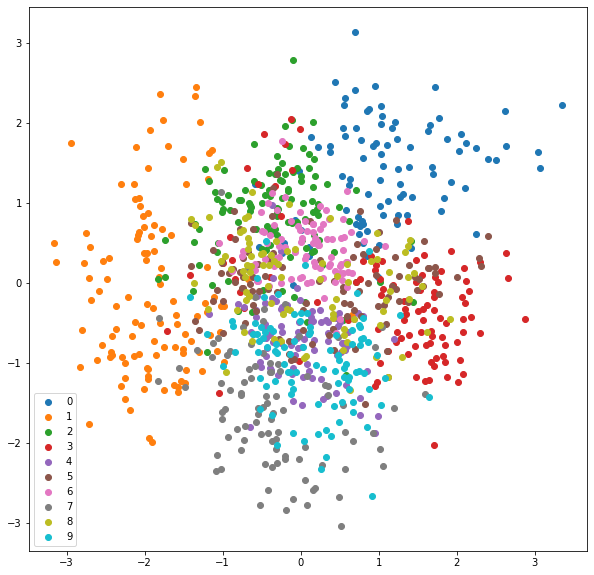

In [33]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f"{cl}")
    
plt.legend()
plt.show()

##### Теперь попробуем нарисовать красивую картинку из лекции

In [34]:
xx = torch.linspace(-1.2, 1.2, 10).to(device)
yy = torch.linspace(-1.2, 1.2, 10).to(device)

xm, ym = torch.meshgrid(xx, yy)

/home/ubuntu/anaconda3/envs/ml/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [35]:
z_vectors = torch.cat([xm.unsqueeze(2), ym.unsqueeze(2)], dim=2)
pred = model_vae.decode(z_vectors.view(-1, 2))
pred = pred.view(10, 10, 28, 28)

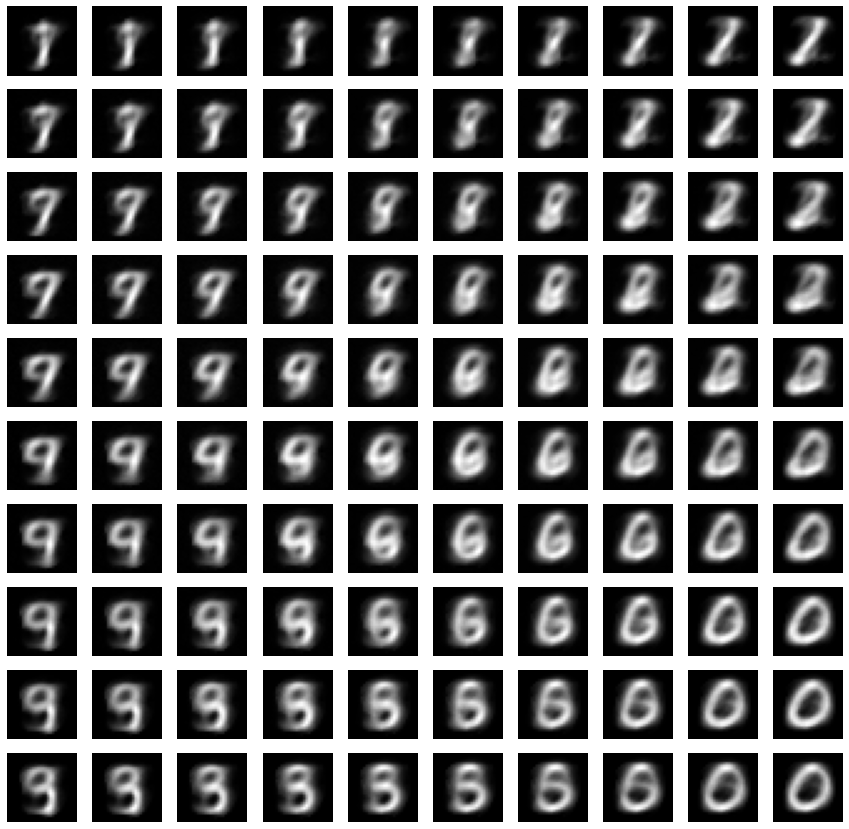

In [36]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for j in range(10):
        axes[i, j].axis("off")
        axes[i, j].imshow(pred[i, j].cpu().detach().numpy(), cmap="gray")

### 5.3 Sampling from the distribution

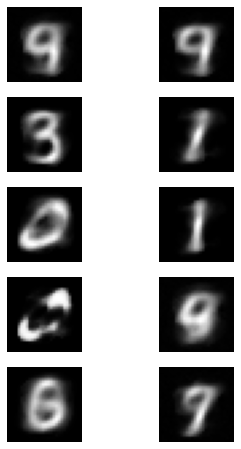

In [37]:
# create 10 samples from latent space and decode them
z = torch.randn(10, 2).to(device)
sampled_from_z = model_vae.decode(z)

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8))

for ax, sampled in zip(axs.flat, sampled_from_z):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap="gray")
    ax.axis("off")

## 6. Conditional VAE

In [38]:
class MNISTEncoder_cvae(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.lat_size = lat_size
        
        self.flatten = nn.Flatten()
        self.enc_net = nn.Sequential( 
            nn.Linear(794, 512), 
            nn.ReLU()
        )
        
        self.mu = nn.Linear(512, self.lat_size)
        self.log_sigma = nn.Linear(512, self.lat_size)
        
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        z = self.flatten(x)
        onehot_y = nn.functional.one_hot(y, 10)
        z = torch.cat([z, onehot_y], dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_cvae(nn.Module):
    def __init__(self, lat_size: int) -> None:
        super().__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size + 10, 512), 
            nn.ReLU(),
            nn.Linear(512, 784), 
            nn.Sigmoid()
        )
        
    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        onehot_y = nn.functional.one_hot(y, 10)
        z_cond = torch.cat([z, onehot_y], dim=1)

        x_reconstructed = self.dec_net(z_cond)
        x_reconstructed = x_reconstructed.view(-1, 1, 28, 28)
        
        return x_reconstructed

In [39]:
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(
        self, 
        lat_size: int, 
        KL_weight: float = 0.001,
        encoder_class: Type[MNISTEncoder_cvae] = MNISTEncoder_cvae, 
        decoder_class: Type[MNISTDecoder_cvae] = MNISTDecoder_cvae,
        criterion_class: Type[nn.MSELoss] = nn.MSELoss
    ) -> None:
        super().__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.enc(x, y)
    
    def decode(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.dec(z, y)
    
    def sample_z(self, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
        eps = torch.randn(mu.size()).to(mu.device)
        
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(
        self, 
        x: torch.Tensor, 
        reconstructed_x: torch.Tensor, 
        mu: torch.Tensor, 
        log_sigma: torch.Tensor
    ) -> torch.Tensor:
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim=1), dim=0)
        reconstruction_loss = self.criterion(x, reconstructed_x)
        
        return KL * self.KL_weight + reconstruction_loss
    
    def compute_loss(
        self, 
        x: torch.Tensor, 
        y: torch.Tensor, 
        return_reconstruction: bool = False
    ) -> Union[tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        mu, log_sigma = self.encode(x, y)
        z = self.sample_z(mu, log_sigma)
        reconstructed_x = self.decode(z, y)
        
        loss = self.custom_loss(x, reconstructed_x, mu, log_sigma)
        
        if return_reconstruction:
            return loss, reconstructed_x
        else:
            return loss

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

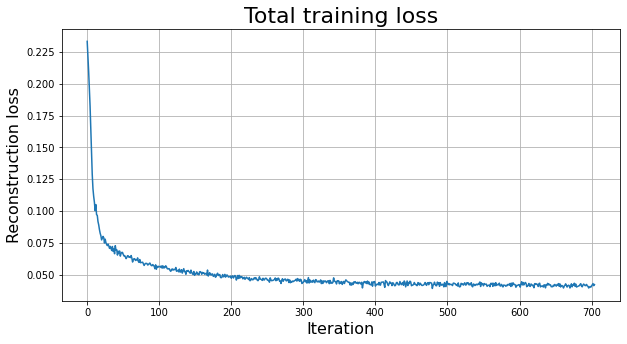

In [40]:
hidden_dim = 2
model_cvae = ConditionalVariationalAutoEncoder(hidden_dim, 0.001)
optimizer = optim.Adam(model_cvae.parameters(), lr=1e-3)

train_model(model_cvae, train_dataloader, optimizer, 3, conditional=True)

In [41]:
z = torch.rand((10, hidden_dim), device=device)
y = torch.arange(10).to(device)

sampled_from_z = model_cvae.decode(z, y)

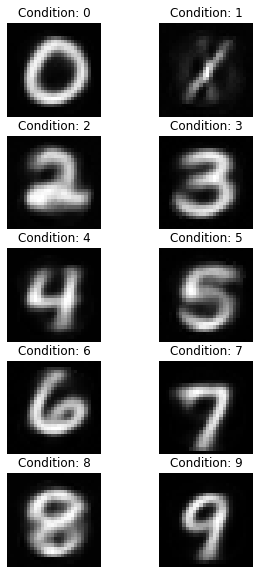

In [42]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 10))

for ax, sampled, label in zip(axs.flat, sampled_from_z, y):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap="gray")
    ax.set_title(f"Condition: {label}")
    ax.axis("off")

In [43]:
def get_latent_codes_and_labels_cvae(
    dataloader: torch.utils.data.DataLoader, 
    model: nn.Module, 
    num_objects: int
) -> tuple[torch.Tensor, torch.Tensor]:
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x, y)
        
        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps
        
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [44]:
lat_codes, labels = get_latent_codes_and_labels_cvae(train_dataloader, model_cvae, 1000)

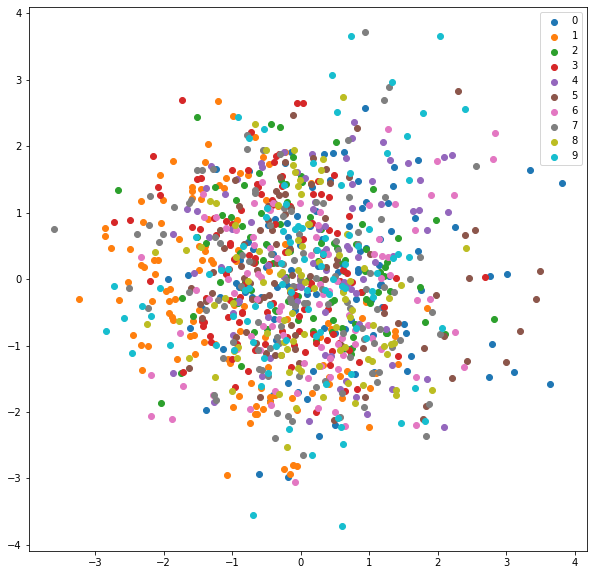

In [45]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f"{cl}")
    
plt.legend()
plt.show()

Статьи с помощью которых реализованы последние 2 секции, довольно подробно поясняющие, что происходит:

* [**VAE**](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [**Conditional VAE**](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/)